In [15]:
# Importaciones iniciales
import sys
from collections import OrderedDict

from mne import create_info, concatenate_raws, preprocessing
from mne.io import RawArray
from mne.channels import read_montage

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

# importar utilidades de muse-lsl
sys.path.append('../muse')
import utils

%matplotlib inline

## Cargar datos desde muse
Se pueden leer datos del dispositivo y guardarlos en un .csv con la utilidad de `lsl-record.py.` 

Ejemplo: `python stimulus_presentation/generate_Visual_P300.py & python lsl-record.py -d 60`

Un problema de esta utilidad es que espera un canal de eventos (markers). En este ejemplo dicho canal es provisto por generate_Visual_P300.py que es un evento propio del repositorio original

## Cargar datos CSV
muse-lsl tiene una utilidad propia para cargar los datos de un .csv. Para utilizarla primero se deben guardar los datos bajo el directorio "data/<nombre>" e invocar la función utils.load_data(). La misma leerá todos los .csv bajo el directorio pasado como argumento y devolverá un objeto del tipo mne.raw.

In [2]:
# Carga los datos desde una carpeta. Espera archivos CSV
subject = 1
session = 1

raw = utils.load_data('Test_EEG', sfreq=256., 
                      subject_nb=subject, session_nb=session, 
                      ch_ind=[0, 1, 2, 3])
raw

Creating RawArray with float64 data, n_channels=5, n_times=7692
    Range : 0 ... 7691 =      0.000 ...    30.043 secs
Ready.


<RawArray  |  None, n_channels x n_times : 5 x 7692 (30.0 sec), ~322 kB, data loaded>

In [54]:
# exlplorar los datos
%matplotlib auto
raw.plot(butterfly=True, group_by='position');

Using matplotlib backend: Qt4Agg


In [55]:
#ver espectro de frecuencia de los EEG
raw.plot_psd(tmax=np.inf);

/home/default/.conda/envs/py27/lib/python2.7/site-packages/mne/viz/raw.py:719: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


Effective window size : 8.000 (s)


Como puede verse, existe un pico en 50Hz y un armónico en 100Hz.
## Filtrado

Para eliminar información que no necesitamos, filtramos entre 1 y 40Hz

Setting up band-pass filter from 1 - 40 Hz
Effective window size : 8.000 (s)


/home/default/.conda/envs/py27/lib/python2.7/site-packages/mne/viz/raw.py:719: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


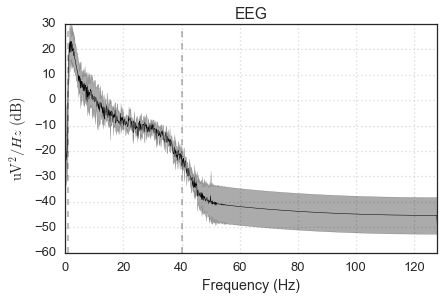

In [9]:
# filtro a 40Hz y grafico el espectro resultante
raw.filter(1,40, method='iir')
raw.plot_psd(tmax=np.inf);

## Epoching
Se dividen los registros en Epochs entre -100ms y 800ms luego del evento. No se hace corrección a la baseline y se rechazan los eventos mayores a 100uV (mayormente parpadeos)

In [28]:
# descubrir eventos desde el EEG crudo
from mne import Epochs, find_events

events = find_events(raw, output='offset')
#elimino el último porque puede quedar cortado
#events = events[5:6] 
event_id = {'Parpadeo': 1}
# start of each epoch (400ms before the trigger)
tmin = -0.4    
# end of each epoch (800ms after the trigger)
tmax = 0.8
#normalmente la función de abajo toma otro comando reject = {eeg=some_value} para eliminar los epochs con ruido.
epochs = Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True, verbose=True)#, picks=[0,1,2,3])
# incidentalmente, existe una función que encuentra automáticamente los artefactos del parpadeo
# pero requiere canales extra que indiquen cuando fue el artefacto.
#eog_events = preprocessing.find_eog_events(raw)

13 events found
Events id: [1]
13 matching events found
0 projection items activated
Loading data for 13 events and 308 original time points ...
0 bad epochs dropped


In [41]:
#muestra los epochs. La presentación es interactiva y al hacer click sobre el Epoch, se los marca como malos
%matplotlib auto 
# block=True significa que la ejecución del programa se bloquea hasta que se cierre la figura
# útil si se quiere marcar canales on the fly.
epochs.plot(block=True);

Using matplotlib backend: Qt4Agg
Dropped 2 epochs
Channels marked as bad: []


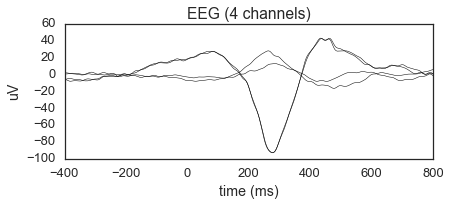

In [42]:
epochsAV = epochs.average()
epochsAV.plot();

En la figura anterior se muestra el promedio de los Epochs para los cuatro canales. Se observa un patrón bastante evidente.. En la figura donde se ven los valores instantáneos de los Epochs se puede apreciar que los identificados como 1 y 2 no presentan la misma figura que los otros. Habrá pues que excluirlos.

In [31]:
epochs.drop([0,1])

Dropped 2 epochs


<Epochs  |  n_events : 11 (all good), tmin : -0.3984375 (s), tmax : 0.80078125 (s), baseline : None, ~153 kB, data loaded>

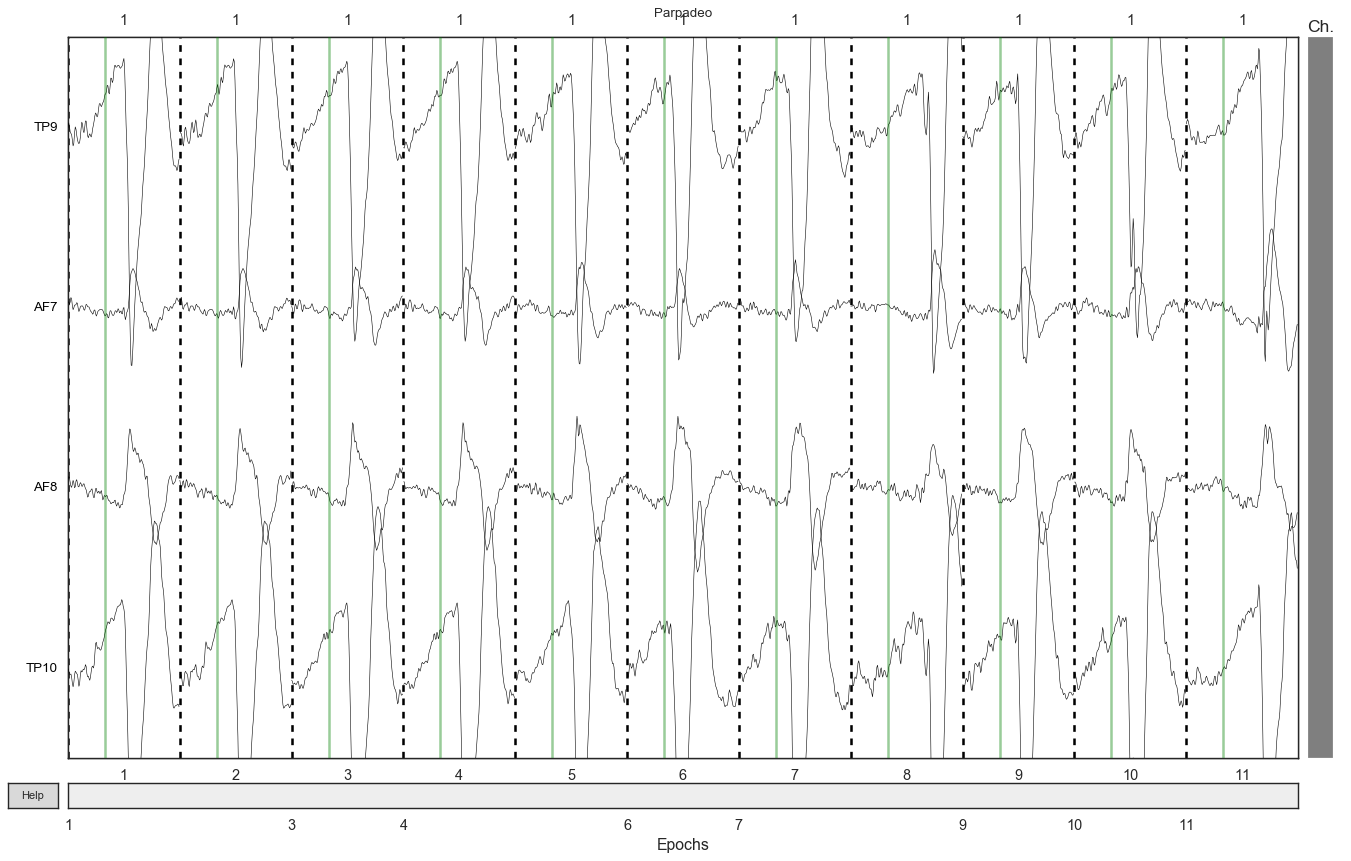

In [32]:
epochs.plot(block=True);

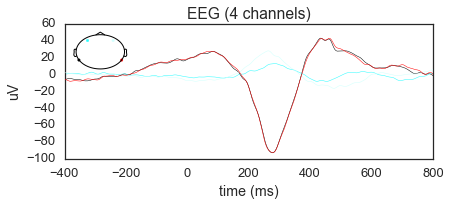

In [48]:
epochsAV = epochs.average()
epochsAV.plot(spatial_colors=True);

In [34]:
len(epochs)

11